# 한글폰트

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
# 여기까지 실행 후 "런타임 다시 시작..." 실행 (이 부분은 실행할 필요 없음)

Selecting previously unselected package fonts-nanum.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 5.6MB/s 


# Evn

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)

['data-20210420T111231Z-001.zip', 'kowiki']

# word2Vec

## Tutorial

In [ ]:
sentences = [
            "나는 학생 입니다",
            "당신은 수학 선생님 입니다",
            "나는 선생님 입니다",
            "당신은 수학 학생 입니다"
]

In [ ]:
words = []
for line in sentences:
    for w in line.split():
        words.append(w)

words = list(dict.fromkeys(words))
words

['나는', '학생', '입니다', '당신은', '수학', '선생님']

In [ ]:
word_to_id = {}
for w in words:
    if w not in word_to_id:
        word_to_id[w] = len(word_to_id)
word_to_id

{'나는': 0, '당신은': 3, '선생님': 5, '수학': 4, '입니다': 2, '학생': 1}

In [ ]:
inputs = np.array([word_to_id['수학']])
labels = np.array([word_to_id['학생']])
inputs, labels

# 중심단어 ;수학
# 주변단어 ;학생


(array([4]), array([1]))

In [ ]:
n_vocab = len(word_to_id)


In [ ]:
v = tf.keras.layers.Embedding(n_vocab, 4)
v_c = v(inputs)
v_c
# v

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00491802,  0.00032756,  0.04579724,  0.00764621]],
      dtype=float32)>

In [ ]:
v.get_weights()

[array([[-0.03675799,  0.03582847,  0.00036023,  0.02038616],
        [-0.00766131,  0.02614349, -0.03912008,  0.00675068],
        [-0.01005335, -0.00819764, -0.04357652, -0.04311752],
        [ 0.0485138 ,  0.00025751, -0.021448  , -0.01007477],
        [-0.00491802,  0.00032756,  0.04579724,  0.00764621],
        [-0.03826857, -0.01651722,  0.04418433, -0.03888126]],
       dtype=float32)]

In [ ]:
U = tf.keras.layers.Dense(n_vocab, use_bias = False)
# U.shape
vU = U(v_c)
vU
# v와 u의 내적을 구함

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[-0.00990729,  0.01676563, -0.02054315, -0.02264868, -0.02898233,
        -0.00279342]], dtype=float32)>

In [ ]:
U.get_weights()[0].shape



(4, 6)

In [ ]:
# 내적했으니까 (1,4) * (4,6) = (1,6)
vU.shape

TensorShape([1, 6])

In [ ]:
# 이제 확률분포로 바꿔부께 cross entropy? softmax?
# 

vU_exp = tf.exp(vU)
vU_exp


<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.99014163, 1.016907  , 0.9796664 , 0.9776059 , 0.97143364,
        0.9972105 ]], dtype=float32)>

In [ ]:
# 이제 썸해서 분모 구해야지
vU_sum  = tf.reduce_sum(vU_exp, axis = 1)
vU_sum

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([5.9329653], dtype=float32)>

In [ ]:
y_prob = vU_exp / vU_sum
y_prob

# 각각의 확률이 일케된다

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.16688816, 0.17139944, 0.16512255, 0.16477525, 0.16373493,
        0.16807961]], dtype=float32)>

In [ ]:
# 이걸 한번에 하면 이걸 쓰면 되지
tf.nn.softmax(vU)

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.16688816, 0.17139946, 0.16512257, 0.16477527, 0.16373494,
        0.16807961]], dtype=float32)>

In [ ]:
y_true = tf.one_hot(labels, n_vocab)
y_true
# (labels, n_vocab)

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[0., 1., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
loss = -y_true * tf.math.log(y_prob)
loss

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.       , 1.7637585, 0.       , 0.       , 0.       , 0.       ]],
      dtype=float32)>

In [ ]:
loss = tf.reduce_sum(loss,axis = 1)
loss

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.7637585], dtype=float32)>

In [ ]:
# 한줄로 loss 구하려면
tf.keras.losses.SparseCategoricalCrossentropy()(labels, y_prob)

<tf.Tensor: shape=(), dtype=float32, numpy=1.7637584>

## Data

In [ ]:
# 입력 문장
sentences = [
    "나는 학생 입니다",
    "당신은 수학 선생님 입니다",
    "나는 선생님 입니다",
    "당신은 수학 학생 입니다"
]

# 출력 정답
targets = [[0, 1, 0],
          [0, 1, 1, 0],
          [0, 1, 0],
          [0, 1, 1, 0]]  # 기타(0), 명사(1)

In [ ]:
id_to_label = {0: "기타", 1: "명사"}

In [ ]:
train_src = sentences[:2]
train_tgt = targets[:2]

train_src, train_tgt

In [ ]:
valid_src = sentences[2:3]
valid_tgt = targets[2:3]

valid_src, valid_tgt

In [ ]:
test_src = sentences[3:]
test_tgt = targets[3:]

test_src, test_tgt

(['당신은 수학 학생 입니다'], [[0, 1, 1, 0]])

## vocabulary

In [ ]:
words = []
for line in sentences:
    for w in line.split():
        words.append(w)

words = list(dict.fromkeys(words))
# words = dict.fromkeys(words)
words

['나는', '학생', '입니다', '당신은', '수학', '선생님']

In [ ]:
word_to_id = {"[PAD]": 0, "[UNK]": 1}
for w in words:
    if w not in word_to_id:
        word_to_id[w] = len(word_to_id)
word_to_id

In [ ]:
id_to_word = {_id:w for w, _id in word_to_id.items()}
id_to_word

{0: '[PAD]',
 1: '[UNK]',
 2: '나는',
 3: '학생',
 4: '입니다',
 5: '당신은',
 6: '수학',
 7: '선생님'}

## Train, Valid, Test 데이터 생성

In [ ]:
def make_data(src, tgt, n_seq):
    inputs, labels = [], []

    for s, t in zip(src, tgt):
        print(s)
        print(t)
        _input = [word_to_id[w] for w in s.split()]
        _input = _input[:n_seq]
        _input = _input + [0] * (n_seq - len(_input))
        inputs.append(_input)

        _label = [n for n in t]
        _label = _label[:n_seq]
        _label = _label + [0] * (n_seq - len(_label))
        labels.append(_label)

    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(train_src, train_tgt, 5)
train_inputs, train_labels

나는 학생 입니다
[0, 1, 0]
당신은 수학 선생님 입니다
[0, 1, 1, 0]


(array([[2, 3, 4, 0, 0],
        [5, 6, 7, 4, 0]]), array([[0, 1, 0, 0, 0],
        [0, 1, 1, 0, 0]]))

In [ ]:
valid_inputs, valid_labels = make_data(valid_src, valid_tgt, 6)
valid_inputs, valid_labels

나는 선생님 입니다
[0, 1, 0]


(array([[2, 7, 4, 0, 0, 0]]), array([[0, 1, 0, 0, 0, 0]]))

In [ ]:
test_inputs, test_labels = make_data(test_src, test_tgt, 4)
test_inputs, test_labels

당신은 수학 학생 입니다
[0, 1, 1, 0]


(array([[5, 6, 3, 4]]), array([[0, 1, 1, 0]]))

## Modeling

In [ ]:
train_inputs = np.random.randint(0, 8, (2, 5))
train_labels = np.random.randint(0, 2, (2, 5))
train_inputs, train_labels

(array([[7, 3, 0, 1, 3],
        [0, 3, 2, 3, 4]]), array([[1, 1, 1, 1, 0],
        [1, 0, 1, 1, 0]]))

In [ ]:
valid_inputs = np.random.randint(0, 8, (1, 6))
valid_labels = np.random.randint(0, 2, (1, 6))
valid_inputs, valid_labels

(array([[2, 3, 6, 4, 1, 7]]), array([[1, 0, 0, 0, 1, 1]]))

In [ ]:
test_inputs = np.random.randint(0, 8, (1, 4))
test_labels = np.random.randint(0, 2, (1, 4))
test_inputs, test_labels

(array([[7, 1, 2, 5]]), array([[0, 0, 1, 1]]))

In [ ]:
embedding = tf.keras.layers.Embedding(len(word_to_id), 3)
hidden = embedding(train_inputs)
hidden

In [ ]:
weight = embedding.get_weights()[0]
weight

In [ ]:
weight[train_inputs]

In [ ]:
# RNN, CNN, Attention

In [ ]:
linear = tf.keras.layers.Dense(2)
logits = linear(hidden)
logits

In [ ]:
# y = Wx + b
weight, bias = linear.get_weights()
weight, bias

In [ ]:
tf.matmul(hidden, weight) + bias

In [ ]:
y_pred = tf.nn.softmax(logits, axis=-1)
y_pred

In [ ]:
linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
y_pred = linear(hidden)
y_pred

In [ ]:
args.n_vocab = len(word_to_id)
args.d_model = 32
args.n_out = 2
args

Namespace(d_model=32, n_out=2, n_vocab=8, seed=1234)

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((None,))

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)
    #
    # RNN, CNN, Attention, Linear
    #
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

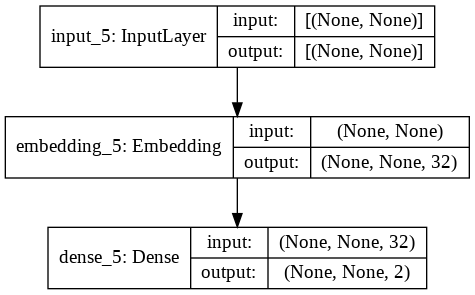

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs)

In [ ]:
model.predict(valid_inputs)

In [ ]:
model.predict(test_inputs)

## Train

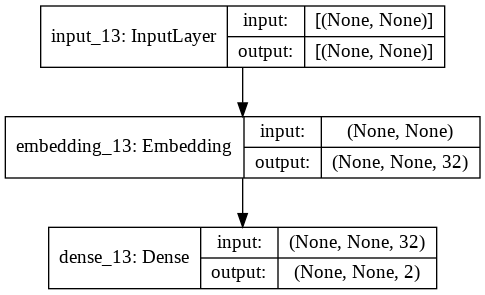

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
train_inputs.shape, train_labels.shape, valid_inputs.shape, valid_labels.shape

((2, 5), (2, 5), (1, 6), (1, 6))

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint("stub.hdf5",
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger("stub.csv")

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=8,
                    validation_data=(valid_inputs, valid_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

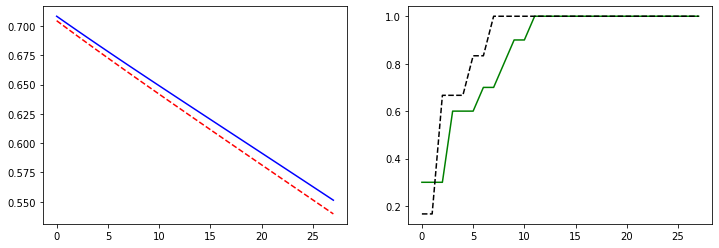

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights("stub.hdf5")

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 0s 256ms/step - loss: 0.6612 - accuracy: 0.5000


[0.6612246036529541, 0.5]

# 배포

In [ ]:
model = build_model(args)
model.load_weights("stub.hdf5")

In [ ]:
string = "수학 당신은 선생님 입니다"

In [ ]:
infer_input = [word_to_id[w] for w in string.split()]
infer_input = np.array([infer_input])
infer_input

array([[6, 5, 7, 4]])

In [ ]:
train_inputs.shape, infer_input.shape

((2, 5), (1, 4))

In [ ]:
y_pred = model.predict(infer_input)
y_pred

array([[[0.43229845, 0.5677016 ],
        [0.5931056 , 0.40689442],
        [0.458534  , 0.541466  ],
        [0.5983461 , 0.40165392]]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([[1, 0, 1, 0]])

In [ ]:
for row in y_class:
    for val in row:
        print(f"{val} : {id_to_label[val]}")

1 : 명사
0 : 기타
1 : 명사
0 : 기타


In [ ]:
def do_predict(model, string):
    tokens = string.split()
    infer_input = []
    for w in tokens:
        infer_input.append(word_to_id.get(w, 1))
    infer_input = np.array([infer_input])
    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    result = []
    for w, c in zip(tokens, y_class):
        result.append([w, id_to_label[c]])
    return result

In [ ]:
do_predict(model, "수학 당신은 과학 선생님 입니다")

[['수학', '명사'], ['당신은', '기타'], ['과학', '기타'], ['선생님', '명사'], ['입니다', '기타']]

In [ ]:
while True:
    print("input> ", end="")
    string = str(input())
    if len(string) == 0:
        break
    result = do_predict(model, string)
    print(result)

input> 나는 중학생 입니다
[['나는', '기타'], ['중학생', '기타'], ['입니다', '기타']]
input> 당신은 우리학교 선생님 입니다.
[['당신은', '기타'], ['우리학교', '기타'], ['선생님', '명사'], ['입니다.', '기타']]
input> 
